In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Victor Hugo
### Les Miserables

In [2]:
BODY_START = 152
BODY_END = 21692
CHAP_PAT = r'^\s*(?:VOLUME|BOOK|CHAPTER).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/The_Hunchback_of_Notre_Dame.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['CHAPTER I. THE GRAND HALL.\n',
 '\n',
 '\n',
 '\n',
 'Three hundred and forty-eight years, six months, and nineteen days ago\n',
 'to-day, the Parisians awoke to the sound of all the bells in the triple\n',
 'circuit of the city, the university, and the town ringing a full peal.\n',
 '\n',
 'The sixth of January, 1482, is not, however, a day of which history has\n',
 'preserved the memory. There was nothing notable in the event which\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,CHAPTER I. THE GRAND HALL.\n
1,\n
2,\n
3,\n
4,"Three hundred and forty-eight years, six month..."


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 152,
    body_end = 21692,
    chap_pat = r'^\s*(?:VOLUME|BOOK|CHAPTER).*$'
)
HND_K, HND_V = text_to_tokens(**cfg)

In [12]:
HND_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
                           2            .         .     1    0      NaN   
                  1        0           DT       THE     0    0      the   
                           1          NNP     GRAND     0    0    grand   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2017  
                           1             6240  
                           2               -1  
                  1        0            12308  
                           1             5554

In [13]:
HND_K = HND_K.loc[HND_K.term_id >= 0]

In [14]:
HND_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
                  1        0           DT       THE     0    0      the   
                           1          NNP     GRAND     0    0    grand   
                           2          NNP      HALL     0    0     hall   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2017  
                           1             6240  
                  1        0            12308  
                           1             5554  
                           2             5748

In [15]:
HND_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,4708,0.025246,a,1
1,aback,1,0.000005,aback,0
2,abandon,3,0.000016,abandon,0
3,abandoned,13,0.000070,abandon,0
4,abandoning,1,0.000005,abandon,0


In [16]:
WORDS = (HND_K.punc == 0) & (HND_K.num == 0) & HND_K.term_id.isin(HND_V[HND_V.stop==0].index)

In [17]:
BOW = HND_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,13710,13711,13712,13713,13714,13715,13716,13717,13718,13719
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * HND_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
HND_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / HND_V[HND_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,13710,13711,13712,13713,13714,13715,13716,13717,13718,13719
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.284556e-09,1.701423e-09,9.655924e-04,2.284556e-09,1.701423e-09,2.284556e-09,1.916640e-09,2.284556e-09,2.284556e-09,2.284556e-09,...,2.284556e-09,1.916640e-09,1.916640e-09,1.916640e-09,2.284556e-09,2.284556e-09,2.284556e-09,2.284556e-09,2.284556e-09,2.284556e-09
1,3.825882e-03,2.849323e-09,1.617048e-09,3.825879e-09,2.849323e-09,3.825879e-09,3.209741e-09,3.825879e-09,3.825879e-09,3.825879e-09,...,3.825879e-09,3.209741e-09,3.209741e-09,3.209741e-09,3.825879e-09,3.825879e-09,3.825879e-09,3.825879e-09,3.825879e-09,3.825879e-09
2,4.939845e-09,3.678950e-09,2.087878e-09,4.939845e-09,3.678950e-09,4.939845e-09,4.144309e-09,4.939845e-09,4.939845e-09,4.939845e-09,...,4.939845e-09,4.144309e-09,4.144309e-09,4.144309e-09,4.939845e-09,4.939845e-09,4.939845e-09,4.939845e-09,4.939845e-09,4.939845e-09
3,3.861567e-09,2.875903e-09,1.632132e-09,3.861567e-09,2.875903e-09,3.861567e-09,3.239685e-03,3.861567e-09,3.861567e-09,3.861567e-09,...,3.861567e-09,3.239682e-09,3.239682e-09,3.239682e-09,3.861567e-09,3.861567e-09,3.861567e-09,3.861567e-09,3.861567e-09,3.861567e-09
4,5.231156e-09,3.895903e-09,2.211003e-09,5.231156e-09,3.895903e-09,5.231156e-09,4.388710e-03,5.231156e-09,5.231156e-09,5.231156e-09,...,5.231156e-09,4.388705e-09,4.388705e-09,4.388705e-09,5.231156e-09,5.231156e-09,5.231156e-09,5.231156e-09,5.231156e-09,5.231156e-09


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,13710,13711,13712,13713,13714,13715,13716,13717,13718,13719
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.456545e-12,5.490209e-12,3.063796e-05,1.511140e-12,6.964404e-12,2.675503e-12,5.641588e-12,3.978150e-12,9.179758e-13,9.179758e-13,...,2.208663e-12,1.149616e-11,5.879402e-12,4.739891e-12,1.298116e-12,3.035131e-12,2.361520e-12,1.927294e-12,8.357397e-13,2.073966e-12
1,4.113909e-06,9.194292e-12,5.130845e-11,2.530662e-12,1.166308e-11,4.480586e-12,9.447804e-12,6.662092e-12,1.537307e-12,1.537307e-12,...,3.698784e-12,1.925228e-11,9.846063e-12,7.937757e-12,2.173917e-12,5.082846e-12,3.954769e-12,3.227583e-12,1.399589e-12,3.473211e-12
2,5.311735e-12,1.187136e-11,6.624773e-11,3.267505e-12,1.505898e-11,5.785182e-12,1.219869e-11,8.601868e-12,1.984919e-12,1.984919e-12,...,4.775745e-12,2.485789e-11,1.271290e-11,1.024896e-11,2.806888e-12,6.562799e-12,5.106264e-12,4.167346e-12,1.807102e-12,4.484492e-12
3,4.152280e-12,9.280059e-12,5.178706e-11,2.554269e-12,1.177188e-11,4.522382e-12,9.535945e-06,6.724237e-12,1.551648e-12,1.551648e-12,...,3.733287e-12,1.943187e-11,9.937910e-12,8.011802e-12,2.194196e-12,5.130260e-12,3.991660e-12,3.257690e-12,1.412645e-12,3.505610e-12
4,5.624976e-12,1.257143e-11,7.015446e-11,3.460195e-12,1.594703e-11,6.126343e-12,1.291807e-05,9.109133e-12,2.101973e-12,2.101973e-12,...,5.057378e-12,2.632380e-11,1.346260e-11,1.085336e-11,2.972414e-12,6.949818e-12,5.407389e-12,4.413101e-12,1.913669e-12,4.748950e-12


In [25]:
HND_V['tf_sum'] = TF.sum()
HND_V['tf_mean'] = TF.mean()
HND_V['tf_max'] = TF.max()
HND_V['tfidf_sum'] = TFIDF.sum()
HND_V['tfidf_mean'] = TFIDF.mean()
HND_V['tfidf_max'] = TFIDF.max()
HND_V['tfth_sum'] = TFTH.sum()
HND_V['tfth_mean'] = TFTH.mean()
HND_V['tfth_max'] = TFTH.max()
HND_V['th_sum'] = THM.sum()
HND_V['th_mean'] = THM.mean()
HND_V['th_max'] = THM.max()

In [53]:
TOPS = pd.DataFrame(index=range(20))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = HND_V.sort_values(key, ascending=False).term_str.head(20).tolist()

In [54]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,book,fifth,book,tenth,book,book,book,fifth
1,one,tenth,tenth,eighth,one,second,one,tenth
2,eleventh,sixth,eighth,fifth,said,ii,said,sixth
3,ninth,fourth,eleventh,ninth,little,eleventh,little,fourth
4,tenth,eleventh,ninth,eleventh,ii,ninth,quasimodo,eleventh
5,eighth,second,fifth,fourth,quasimodo,tenth,upon,second
6,second,eighth,sixth,sixth,gringoire,eighth,like,eighth
7,third,book,fourth,third,upon,third,gringoire,book
8,sixth,third,volume,volume,like,sixth,de,third
9,fourth,ninth,third,contents,de,fourth,two,ninth


In [28]:
HND_V = HND_V[HND_V['stop'] == 0]

In [29]:
HND_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
1,aback,1,0.000005,aback,0,1.0,0.000621,0.000008,0.000616,0.003857,0.000052,0.003826,0.000004,5.604377e-08,0.000004,0.006677,0.000090,0.006571
2,abandon,3,0.000016,abandon,0,3.0,0.001360,0.000018,0.000680,0.006290,0.000085,0.003146,0.000020,2.742967e-07,0.000010,0.014922,0.000202,0.007157
3,abandoned,13,0.000070,abandon,0,12.0,0.008100,0.000109,0.001248,0.021259,0.000287,0.003274,0.000675,9.115387e-06,0.000104,0.083274,0.001125,0.012036
4,abandoning,1,0.000005,abandon,0,1.0,0.000353,0.000005,0.000348,0.002194,0.000030,0.002163,0.000001,1.960966e-08,0.000001,0.004107,0.000056,0.004001
5,abandonment,4,0.000021,abandon,0,3.0,0.001796,0.000024,0.001056,0.008305,0.000112,0.004883,0.000034,4.593918e-07,0.000020,0.018929,0.000256,0.010440


In [30]:
D = get_docs(HND_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [31]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [32]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,chapter i the grand hall three hundred and for...,2718,0.029304
1,chapter ii pierre gringoire nevertheless as be...,1623,0.017498
2,chapter iii monsieur the cardinal poor gringoi...,1257,0.013552
3,chapter iv master jacques coppenole while the ...,1608,0.017337
4,chapter v quasimodo in the twinkling of an eye...,1187,0.012798


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

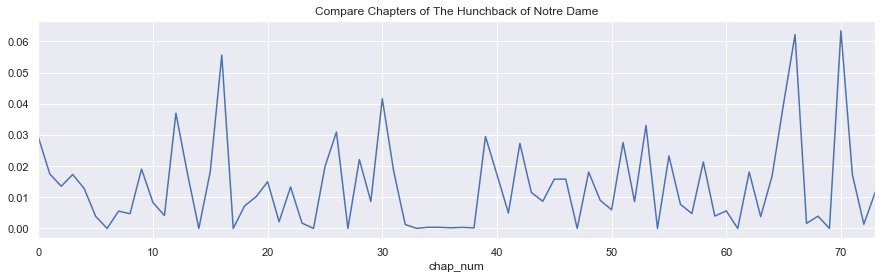

In [33]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of The Hunchback of Notre Dame')

In [34]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [35]:
HND_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
HND_P.index.names = ['doc_x','doc_y']

In [36]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [37]:
HND_P['euclidean'] = 0
HND_P['euclidean'] = HND_P.apply(euclidean, 1)

In [38]:
HND_PME = HND_P.euclidean.unstack().fillna(0)

In [39]:
HND_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.142663,0.141096,0.140196,0.132271,0.180298,1.068127,0.185111,0.191482,0.122878,0.146817,...,0.132725,0.111182,0.120989,0.243282,0.216407,2.205160,0.108294,0.121970,0.301767,0.164336
1,0.000000,0.164393,0.155585,0.155344,0.195264,1.071477,0.204384,0.214199,0.149680,0.169048,...,0.158562,0.141917,0.150767,0.256666,0.234071,2.206860,0.137433,0.149727,0.311584,0.186461
2,0.000000,0.000000,0.148071,0.158244,0.199195,1.070154,0.199945,0.211117,0.150349,0.170248,...,0.157523,0.141782,0.146206,0.256117,0.233187,2.206432,0.137336,0.149756,0.313388,0.185687
3,0.000000,0.000000,0.000000,0.148481,0.194298,1.073183,0.204325,0.212936,0.151878,0.170226,...,0.159317,0.143348,0.142006,0.257013,0.234545,2.206958,0.139431,0.152478,0.315026,0.188676
4,0.000000,0.000000,0.000000,0.000000,0.188296,1.070419,0.196459,0.205399,0.134550,0.158065,...,0.146588,0.126225,0.136568,0.249979,0.225137,2.206116,0.125071,0.135921,0.309368,0.178274


In [40]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [41]:
HND_P['cosine'] = HND_P.apply(cosine, 1)
HND_PMC = HND_P.cosine.unstack().fillna(0)
HND_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.00064,0.000634,0.000838,0.000580,0.000831,0.000696,0.000495,0.000511,0.000446,0.000400,...,0.000350,0.000402,0.000479,0.000379,0.000300,0.000002,0.000335,0.000338,0.000590,0.000419
1,0.00000,0.000707,0.001377,0.000746,0.001205,0.000785,0.000499,0.000207,0.000487,0.000494,...,0.000349,0.000356,0.000378,0.000551,0.000222,0.000002,0.000405,0.000334,0.000866,0.000378
2,0.00000,0.000000,0.001660,0.000495,0.000806,0.001336,0.000730,0.000368,0.000374,0.000341,...,0.000334,0.000289,0.000540,0.000518,0.000227,0.000269,0.000331,0.000255,0.000576,0.000355
3,0.00000,0.000000,0.000000,0.001208,0.001357,0.000003,0.000578,0.000380,0.000443,0.000498,...,0.000381,0.000358,0.000914,0.000600,0.000258,0.000002,0.000379,0.000253,0.000549,0.000305
4,0.00000,0.000000,0.000000,0.000000,0.001117,0.000553,0.000494,0.000288,0.000691,0.000568,...,0.000425,0.000540,0.000536,0.000588,0.000377,0.000002,0.000408,0.000476,0.000532,0.000334


## Cosine Similarity

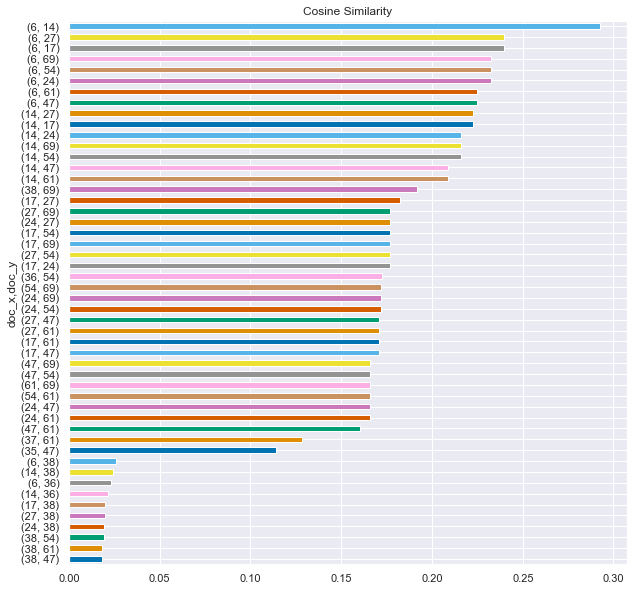

In [42]:
HND_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


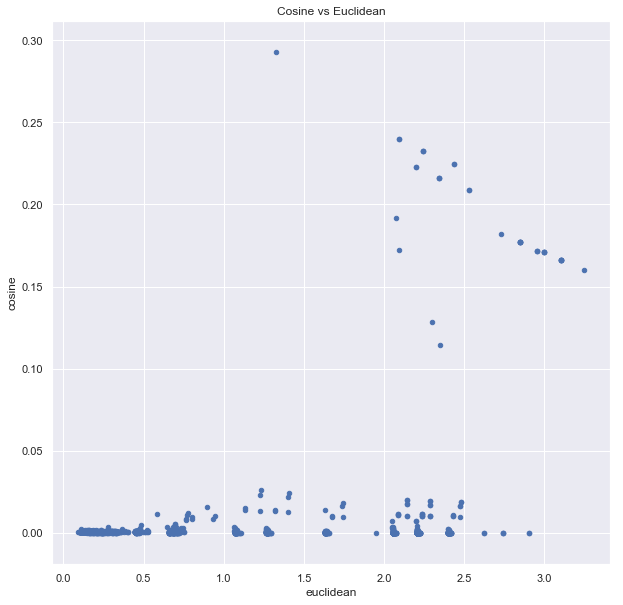

In [43]:
HND_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [44]:
import matplotlib.pyplot as plt

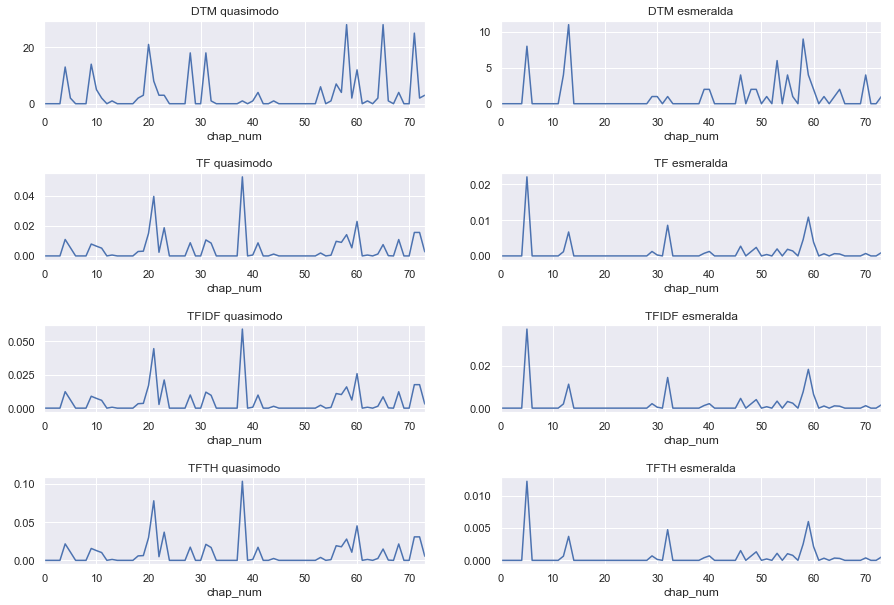

In [55]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('quasimodo esmeralda'.split()):
    W = get_term_id(HND_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

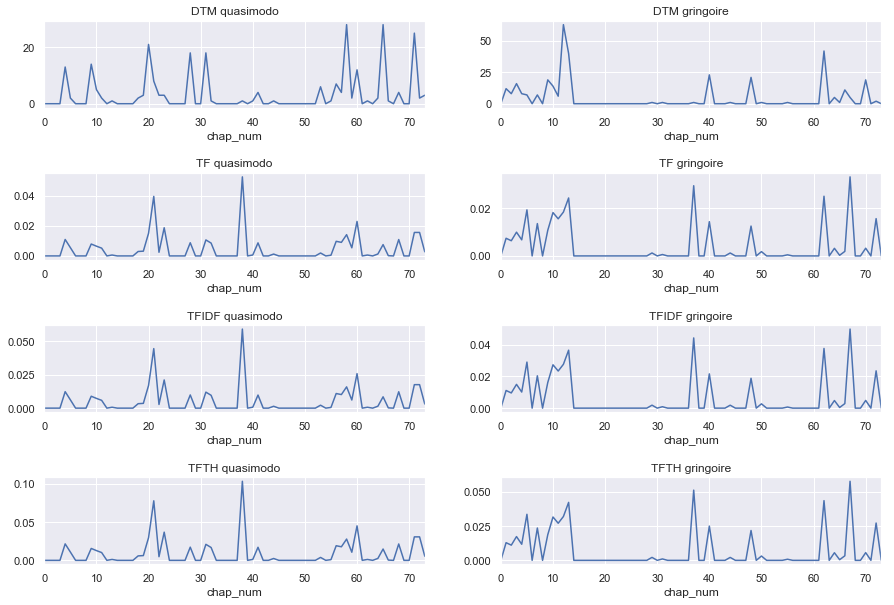

In [56]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('quasimodo gringoire'.split()):
    W = get_term_id(HND_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [57]:
HND_V.to_csv('The_Hunchabck_of_Notre_Dame_V.csv', index=False)

## Visualize KDE Plots

In [58]:
HND_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
                  1        0           DT       THE     0    0      the   
                           1          NNP     GRAND     0    0    grand   
                           2          NNP      HALL     0    0     hall   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2017  
                           1             6240  
                  1        0            12308  
                           1             5554  
                           2             5748

In [59]:
lmk = HND_K.copy()

In [60]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                  
0        0        0        0          chapter     2017
                           1                i     6240
                  1        0              the    12308
                           1            grand     5554
                           2             hall     5748

In [61]:
K = tt.reset_index()

In [62]:
K.rename_axis('offset', inplace=True)

In [63]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,chapter,i,the,grand,hall,three,hundred,and,forty,eight,years
term_id,2017,6240,12308,5554,5748,12404,6188,444,5090,4080,13674


In [64]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [65]:
V1 = HND_V[(HND_V[vocab_weight] > HND_V[vocab_weight].quantile(vocab_weight_quantile)) & (HND_V.n >= vocab_min_n)]

In [66]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,1391,12279,4083,4118,8274,4820,11255,5113,13277,12371
term_str,book,tenth,eighth,eleventh,ninth,fifth,sixth,fourth,volume,third
n,65,3,3,5,4,4,7,7,4,25
p,0.000348555,1.60872e-05,1.60872e-05,2.6812e-05,2.14496e-05,2.14496e-05,3.75367e-05,3.75367e-05,2.14496e-05,0.00013406
port_stem,book,tenth,eighth,eleventh,ninth,fifth,sixth,fourth,volum,third
stop,0,0,0,0,0,0,0,0,0,0
df,28,3,3,4,4,4,5,5,4,17
tf_sum,4.68201,0.526192,0.525352,0.551862,0.545972,0.499235,0.502144,0.499744,0.259158,0.510617
tf_mean,0.0632704,0.0071107,0.00709936,0.0074576,0.007378,0.00674642,0.00678573,0.0067533,0.00350213,0.00690023
tf_max,0.496594,0.496594,0.496594,0.496594,0.496594,0.496594,0.496594,0.496594,0.249146,0.496594
tfidf_sum,6.56463,2.43337,2.42949,2.32304,2.29824,2.10151,1.9521,1.94277,1.09091,1.08352


In [67]:
TOP_TERMS = HND_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [68]:
TOP_TERMS

['book',
 'tenth',
 'eighth',
 'eleventh',
 'ninth',
 'fifth',
 'sixth',
 'fourth',
 'volume',
 'third',
 'contents',
 'ii',
 'second',
 'table',
 'gringoire',
 'iii',
 'quasimodo',
 'leaf',
 'v',
 'vi',
 'key',
 'pinnbus',
 'iv',
 'marriage',
 'ivearthenware',
 'crown',
 'shoe',
 'claude',
 'phoebus',
 'edition']

In [69]:
K = K[K.term_id.isin(V1.index)]

In [70]:
K.head(11).T

offset,3,4,5,6,10,11,15,18,24,28,35
term_str,grand,hall,three,hundred,years,six,days,day,sound,bells,city
term_id,5554,5748,12404,6188,13674,11252,3170,3167,11479,1163,2198


In [71]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [72]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [73]:
B.head()

,offset,x
term_str,,
able,"[1461, 6712, 7396, 16807, 25890, 30465, 32360,...","[[1461], [6712], [7396], [16807], [25890], [30..."
accordance,"[8481, 38064, 58349, 72612, 81220, 95586, 9606...","[[8481], [38064], [58349], [72612], [81220], [..."
accounts,"[21986, 58516, 99337, 100108, 107068, 111031, ...","[[21986], [58516], [99337], [100108], [107068]..."
accused,"[69513, 69828, 69837, 69908, 69916, 70040, 701...","[[69513], [69828], [69837], [69908], [69916], ..."
added,"[3693, 6253, 6629, 9732, 16160, 16629, 25775, ...","[[3693], [6253], [6629], [9732], [16160], [166..."


In [74]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [75]:
B.head()

,offset,x,kde,scores
term_str,,,,
able,"[1461, 6712, 7396, 16807, 25890, 30465, 32360,...","[[1461], [6712], [7396], [16807], [25890], [30...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-11.948407671298883, -11.919668591735284, -11..."
accordance,"[8481, 38064, 58349, 72612, 81220, 95586, 9606...","[[8481], [38064], [58349], [72612], [81220], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-13.17726403761386, -13.114636458607936, -13...."
accounts,"[21986, 58516, 99337, 100108, 107068, 111031, ...","[[21986], [58516], [99337], [100108], [107068]...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-21.183257186300743, -21.019792814702498, -20..."
accused,"[69513, 69828, 69837, 69908, 69916, 70040, 701...","[[69513], [69828], [69837], [69908], [69916], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-108.0175799575685, -107.4972936406671, -106...."
added,"[3693, 6253, 6629, 9732, 16160, 16629, 25775, ...","[[3693], [6253], [6629], [9732], [16160], [166...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.877145457413258, -12.83593317625408, -12...."


In [76]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

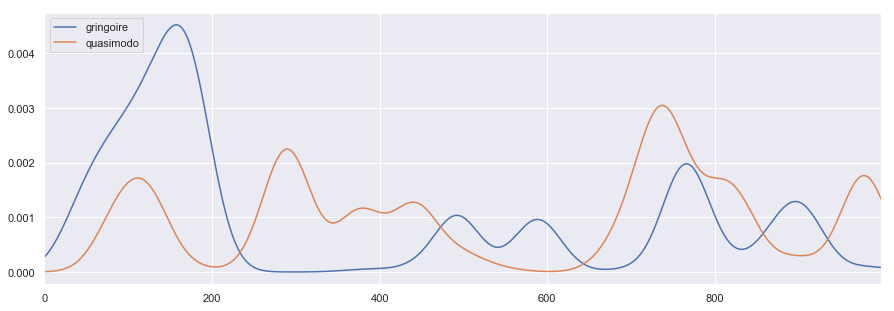

In [77]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['gringoire'].plot(**FIG)
PLOTS.loc['quasimodo'].plot(**FIG)
plt.legend(loc='upper left') 

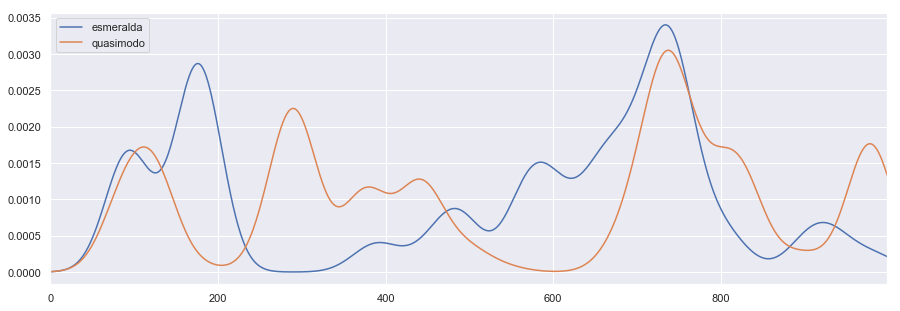

In [78]:
PLOTS.loc['esmeralda'].plot(**FIG)
PLOTS.loc['quasimodo'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [79]:
WORDS = (HND_K.punc == 0) & (HND_K.num == 0) & HND_K.term_id.isin(HND_V[HND_V.stop==0].index)

In [80]:
BOW = HND_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [81]:
DTM = BOW.unstack().fillna(0)

In [82]:
alpha = .000001 
alpha_sum = alpha * HND_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [83]:
N_docs = DTM.shape[0]
HND_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / HND_V[HND_V.stop==0]['df'])

In [84]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,13710,13711,13712,13713,13714,13715,13716,13717,13718,13719
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.284556e-09,1.701423e-09,9.655925e-04,2.284556e-09,1.701423e-09,2.284556e-09,1.916640e-09,2.284556e-09,2.284556e-09,2.284556e-09,...,2.284556e-09,1.916640e-09,1.916640e-09,1.916640e-09,2.284556e-09,2.284556e-09,2.284556e-09,2.284556e-09,2.284556e-09,2.284556e-09
1,3.825883e-03,2.849324e-09,1.617048e-09,3.825879e-09,2.849324e-09,3.825879e-09,3.209741e-09,3.825879e-09,3.825879e-09,3.825879e-09,...,3.825879e-09,3.209741e-09,3.209741e-09,3.209741e-09,3.825879e-09,3.825879e-09,3.825879e-09,3.825879e-09,3.825879e-09,3.825879e-09
2,4.939846e-09,3.678951e-09,2.087878e-09,4.939846e-09,3.678951e-09,4.939846e-09,4.144310e-09,4.939846e-09,4.939846e-09,4.939846e-09,...,4.939846e-09,4.144310e-09,4.144310e-09,4.144310e-09,4.939846e-09,4.939846e-09,4.939846e-09,4.939846e-09,4.939846e-09,4.939846e-09
3,3.861568e-09,2.875903e-09,1.632132e-09,3.861568e-09,2.875903e-09,3.861568e-09,3.239686e-03,3.861568e-09,3.861568e-09,3.861568e-09,...,3.861568e-09,3.239682e-09,3.239682e-09,3.239682e-09,3.861568e-09,3.861568e-09,3.861568e-09,3.861568e-09,3.861568e-09,3.861568e-09
4,5.231156e-09,3.895904e-09,2.211003e-09,5.231156e-09,3.895904e-09,5.231156e-09,4.388710e-03,5.231156e-09,5.231156e-09,5.231156e-09,...,5.231156e-09,4.388706e-09,4.388706e-09,4.388706e-09,5.231156e-09,5.231156e-09,5.231156e-09,5.231156e-09,5.231156e-09,5.231156e-09


## Principal Component Analysis

In [85]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [86]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,-0.116072,0.000043
1,-0.116018,0.000056
2,-0.115537,0.000050
3,-0.117217,0.000064
4,-0.116817,0.000056
5,-0.117625,0.000066
6,0.391287,-0.000042
7,-0.117331,0.000058
8,-0.114930,0.000039
9,-0.117125,0.000063


In [87]:
X = np.array(pca1)
X

array([[-1.16071522e-01,  4.33871797e-05],
       [-1.16017652e-01,  5.60960496e-05],
       [-1.15537049e-01,  4.97854786e-05],
       [-1.17217225e-01,  6.35449935e-05],
       [-1.16816520e-01,  5.64409478e-05],
       [-1.17624830e-01,  6.61525399e-05],
       [ 3.91286778e-01, -4.15122806e-05],
       [-1.17330654e-01,  5.84374324e-05],
       [-1.14930426e-01,  3.89076734e-05],
       [-1.17125443e-01,  6.32321542e-05],
       [-1.17277652e-01,  6.82730311e-05],
       [-1.15656828e-01,  6.30945349e-05],
       [-1.16697562e-01,  7.29159535e-05],
       [-1.16667220e-01,  8.00301730e-05],
       [ 4.19788378e-01, -4.61720803e-05],
       [-1.16828144e-01,  3.29868535e-05],
       [-1.15030535e-01,  4.68127838e-05],
       [ 7.16101538e-01, -1.23286904e-04],
       [-1.17002199e-01,  4.24718866e-05],
       [-1.16439536e-01,  2.88301940e-05],
       [-1.16810409e-01,  3.92378174e-05],
       [-1.18267441e-01,  4.78015813e-05],
       [-1.14688987e-01,  4.30236541e-05],
       [-1.

In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [89]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [90]:
print(pca.explained_variance_)

[0.10188853 0.07251445]


In [91]:
print(pca.mean_)

[ 1.14397981e-17 -3.29515962e-17]


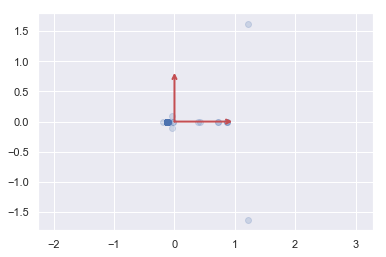

In [92]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [93]:
import sqlite3

In [94]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [102]:
text_db = 'db/The_Hunchback_of_Notre_Dame.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [103]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [104]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [105]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [106]:
emo_cols = combo.columns

In [107]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [108]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [109]:
tokens = tokens.join(combo, on='term_str', how='left')

In [110]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
66        36        0         56          NaN
44        32        0         3           NaN
49        26        0         3           NaN
16        63        1         0           NaN
66        6         1         25          NaN
42        16        6         8           NaN
71        18        2         20          NaN
          44        0         31          NaN
65        11        2         2           NaN
12        12        0         8           NaN
Name: bing_sentiment, dtype: float64

In [111]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [112]:
tokens.head(10)

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
                  1        0           DT       THE     0    0      the   
                           1          NNP     GRAND     0    0    grand   
                           2          NNP      HALL     0    0     hall   
         1        0        0           CD     Three     0    0    three   
                           1           CD   hundred     0    0  hundred   
                           2           CC       and     0    0      and   
                           3           VB     forty     0    0    forty   
                           5           CD     eight     0    0    eight   

                                      term_id  nrc_anger  nrc_anticipation  \
chap_num para_num sent_num token_num                                         
0        0        0        0             2017        0.0               0.0   
                           1             6240        0.0               0.0   
                  1        0            12308        0.0               0.0   
                           1             5554        0.0               0.0   
                           2             5748        0.0               0.0   
         1        0        0            12404        0.0               0.0   
                           1             6188        0.0               0.0   
                           2              444        0.0               0.0   
                           3             5090        0.0               0.0   
                           5             4080        0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
chap_num para_num sent_num token_num                                   
0        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                  1        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   
         1        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   
                           3                  0.0       0.0      0.0   
                           5                  0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                  1        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   
         1        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   
                           3                   0.0           0.0          0.0   
                           5                   0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
chap_num para_num sent_num token_num                                           
0        0        0        0                   0.0        0.0            0.0   
                           1                   0.0        0.0            0.0   
                  1        0              

In [113]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

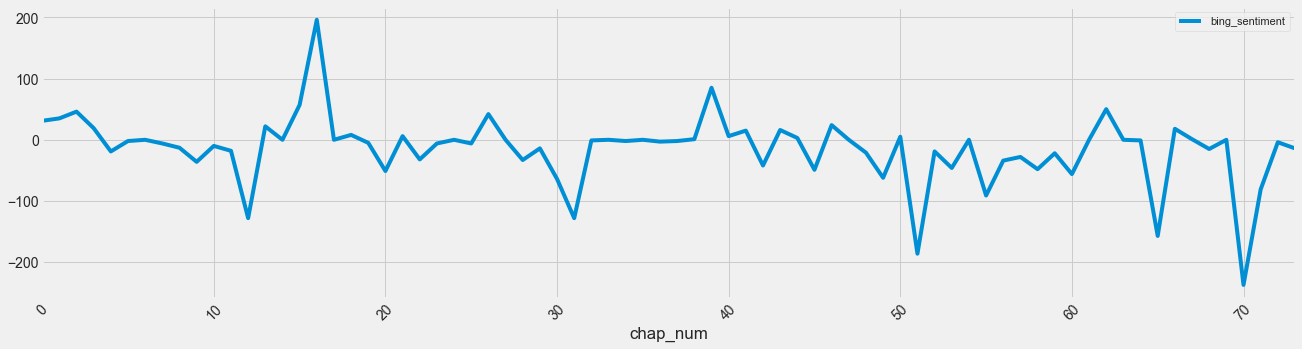

In [114]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [115]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [116]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [117]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0            <span class='sent0'>CHAPTER</span>
                              1                  <span class='sent0'>I</span>
                    1         0                <span class='sent0'>THE</span>
                              1              <span class='sent1'>GRAND</span>
                              2               <span class='sent0'>HALL</span>
Name: html, dtype: object

In [118]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [119]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,chapter i the grand hall three hundred and for...,<span class='sent0'>CHAPTER</span> <span class...
1,chapter ii pierre gringoire nevertheless as be...,<span class='sent0'>CHAPTER</span> <span class...
2,chapter iii monsieur the cardinal poor gringoi...,<span class='sent0'>CHAPTER</span> <span class...
3,chapter iv master jacques coppenole while the ...,<span class='sent0'>CHAPTER</span> <span class...
4,chapter v quasimodo in the twinkling of an eye...,<span class='sent0'>CHAPTER</span> <span class...


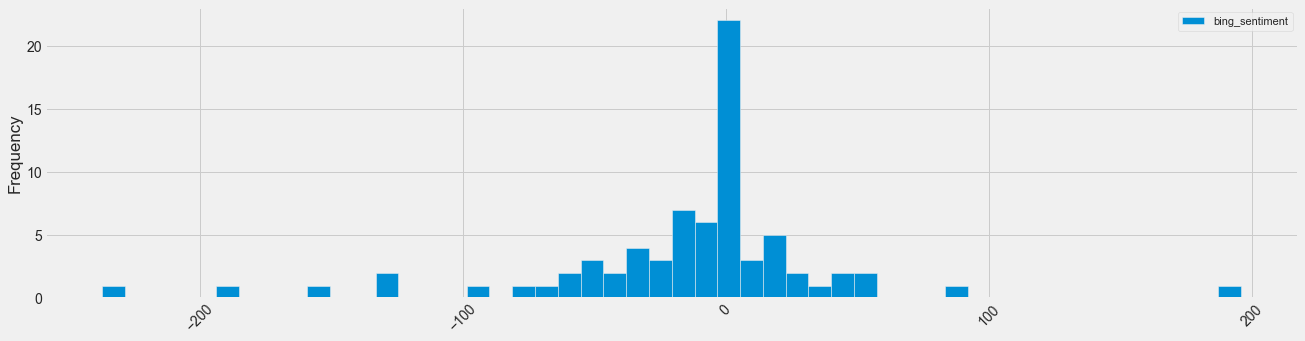

In [120]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [121]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
16,196.0,chapter ii a bird s eye view of paris we have ...
39,85.0,chapter i the danger of confiding one s secret...
15,57.0,chapter i notre dame the church of notre dame ...
62,50.0,chapter i gringoire has many good ideas in suc...
2,46.0,chapter iii monsieur the cardinal poor gringoi...
26,42.0,chapter ii this will kill that our lady reader...
1,35.0,chapter ii pierre gringoire nevertheless as be...
0,31.0,chapter i the grand hall three hundred and for...
46,24.0,chapter viii the utility of windows which open...


### Negative

In [122]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
70,-237.0,chapter i the little shoe la esmeralda was sle...
51,-186.0,chapter iv lasciate ogni speranza leave all ho...
65,-157.0,chapter iv an awkward friend that night quasim...
12,-128.0,chapter vi the broken jug after having run for...
31,-128.0,chapter iv a tear for a drop of water these wo...
55,-91.0,chapter i delirium claude frollo was no longer...
71,-81.0,chapter ii the beautiful creature clad in whit...
30,-64.0,chapter iii history of a leavened cake of maiz...
49,-62.0,chapter ii continuation of the crown which was...


### Multinomial Emotions

In [123]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [124]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


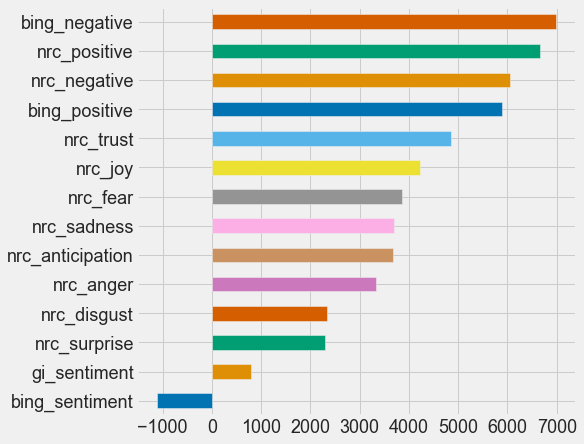

In [125]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [126]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [127]:
B.head()

,x
emo,
nrc_anger,"[[89], [105], [128], [194], [221], [262], [335..."
nrc_anticipation,"[[37], [81], [119], [127], [177], [237], [249]..."
nrc_disgust,"[[120], [128], [194], [733], [741], [754], [14..."
nrc_fear,"[[89], [119], [128], [221], [335], [475], [485..."
nrc_joy,"[[65], [102], [127], [177], [237], [249], [353..."


In [128]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

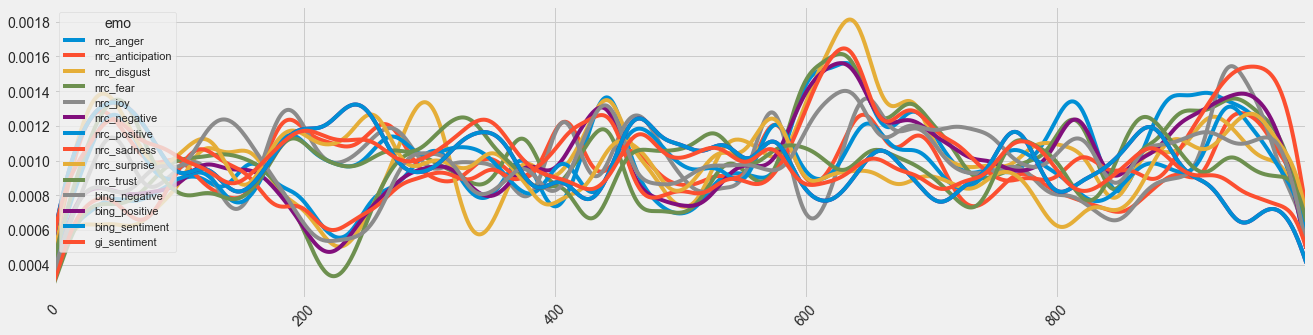

In [129]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

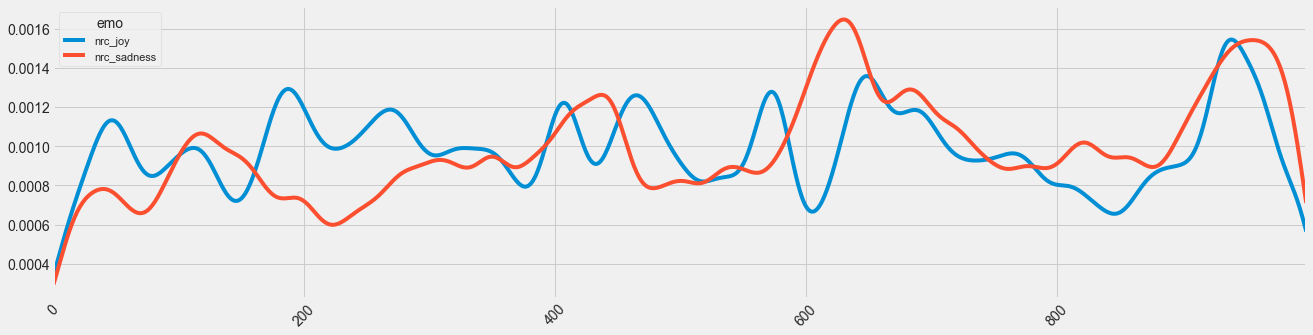

In [130]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

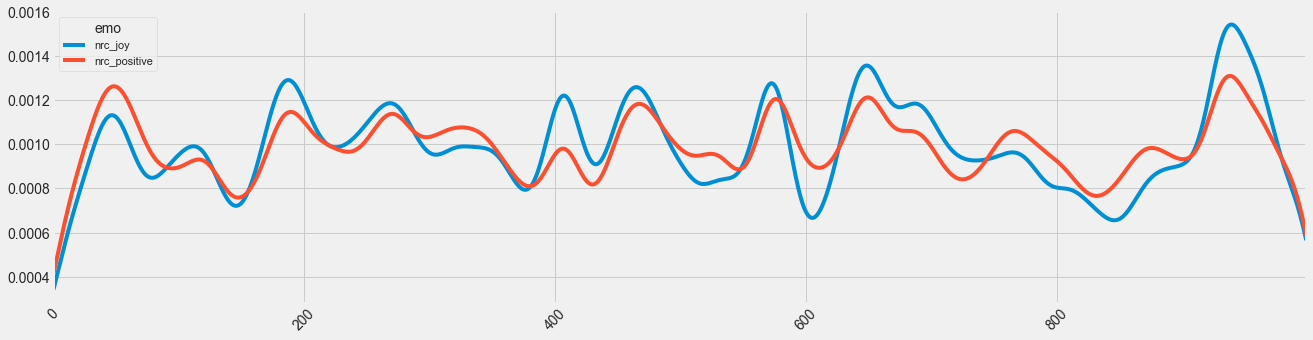

In [131]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

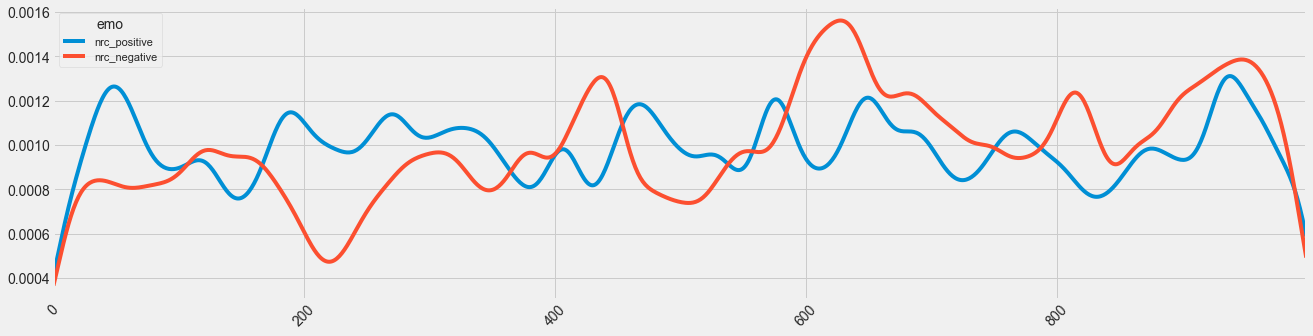

In [132]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

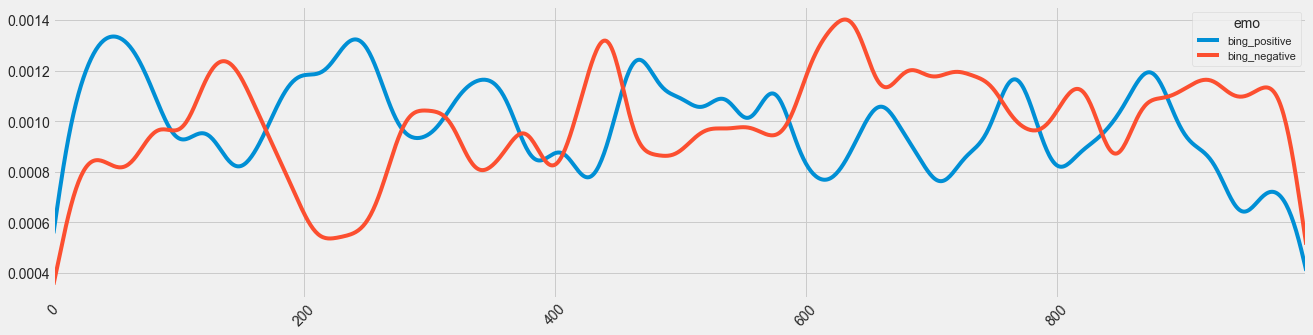

In [133]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)